<a href="https://colab.research.google.com/github/effepivi/gvxr-tutorials/blob/main/PoissonNoise.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Session 7

## Simulating X-ray images with specific Poisson noise using ![gVXR](https://github.com/effepivi/gvxr-tutorials/blob/main/img/gvxr_logo.png?raw=1)

## Author: Franck Vidal

(version 1.0, 10 Mar 2023)

# Aims of this session

1. Add Poisson noise corresponding to a given number of photons per pixel;
2. Simulate the corresponding CT scan; and
3. Reconstruct the CT volume using the [Core Imaging Library (CIL)](https://ccpi.ac.uk/cil/).

# Main steps

1. Simulate an X-ray projection of a Welsh dragon made of quartz

![Simulation of an X-ray projection of a Welsh dragon made of quartz](https://github.com/effepivi/gvxr-tutorials/blob/main/PoissonNoise/visualisation.png?raw=1)

2. Select the number of incident photons per pixel
3. Add the corresponding amount of Photonic noise 

![X-ray projection with Poisson noise](https://github.com/effepivi/gvxr-tutorials/blob/main/PoissonNoise/noisy-projection.png?raw=1)

4. Simulate a CT scan

![Scanning eometry](https://github.com/effepivi/gvxr-tutorials/blob/main/PoissonNoise/CT-geometry.png?raw=1)

5. Create the flat-field images with the corresponding amount of Photonic noise

![Average flat-field image with Poisson noise](https://github.com/effepivi/gvxr-tutorials/blob/main/PoissonNoise/average-flat-field.png?raw=1)

6. Reconstruct the CT volume using the [Core Imaging Library (CIL)](https://ccpi.ac.uk/cil/)

![Visualisation of the reconstructed 3D volume](https://github.com/effepivi/gvxr-tutorials/blob/main/PoissonNoise/plotCT.png?raw=1)

In [1]:
!pip install -q condacolab
import condacolab
condacolab.install()

⏬ Downloading https://github.com/jaimergp/miniforge/releases/latest/download/Mambaforge-colab-Linux-x86_64.sh...
📦 Installing...
📌 Adjusting configuration...
🩹 Patching environment...
⏲ Done in 0:00:23
🔁 Restarting kernel...


# Install gVXR, k3D, imagecodecs xpecgen, spekpy and SimpleITK

Run the cell below

```python
!pip3 install gvxr k3d imagecodecs xpecgen git+https://bitbucket.org/spekpy/spekpy_release.git SimpleITK itk-rtk
```

In [1]:
!pip3 install gvxr k3d imagecodecs xpecgen git+https://bitbucket.org/spekpy/spekpy_release.git SimpleITK itk-rtk

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://bitbucket.org/spekpy/spekpy_release.git to /tmp/pip-req-build-uuqgk7fd
  Running command git clone --filter=blob:none --quiet https://bitbucket.org/spekpy/spekpy_release.git /tmp/pip-req-build-uuqgk7fd
  Resolved https://bitbucket.org/spekpy/spekpy_release.git to commit 53a8dff4e6a11aead2e649242a5bd0eb4980ab86
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 MB 14.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.0/23.0 MB 64.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 36.1/36.1 MB 15.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 906.5/906.5 kB 67.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.7/52.7 MB 13.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.9/23.9 MB 16.6 MB/s eta 0:00:00
   

In [1]:
!mamba install -c conda-forge -c intel -c astra-toolbox -c ccpi cil numpy astra-toolbox --quiet

Preparing transaction: ...working... done
Verifying transaction: ...working... done
Executing transaction: ...working... By downloading and using the CUDA Toolkit conda packages, you accept the terms and conditions of the CUDA End User License Agreement (EULA): https://docs.nvidia.com/cuda/eula/index.html

done


In [2]:
%matplotlib inline

# Copy files

This step is needed when the notebook is executed using Goggle Collaborative

Download the Sample if needed

In [3]:
import os
import urllib.request

def createDirectory(directory):
    # The directory does not exist
    if not os.path.exists(os.path.abspath(directory)):
    
        # Create the directory
        os.mkdir(os.path.abspath(directory))

def downloadFile(fname):
    if not os.path.exists(fname):
        base_url = "https://github.com/effepivi/gvxr-tutorials/raw/main"
        url = base_url + "/" + fname
        print("Download the polygon mesh (%s)" % fname)
        urllib.request.urlretrieve(url, fname)

createDirectory("JSON")
createDirectory("input_data")
createDirectory("PoissonNoise")

downloadFile("input_data/welsh-dragon-small.stl")
downloadFile("energyResponseDetector.txt")
downloadFile("JSON/PoissonNoise.json")
downloadFile("PoissonNoise/visualisation.png")

Download the polygon mesh (input_data/welsh-dragon-small.stl)
Download the polygon mesh (energyResponseDetector.txt)
Download the polygon mesh (JSON/PoissonNoise.json)
Download the polygon mesh (PoissonNoise/visualisation.png)


In [49]:
import glob

from IPython.display import display
from IPython.display import Image

import matplotlib.pyplot as plt # Plotting
import numpy as np

from tifffile import imread, imwrite

from IPython.display import display
from IPython.display import Image

import SimpleITK as sitk

import matplotlib # To plot images

font = {'family' : 'serif',
         'size'   : 10
       }
matplotlib.rc('font', **font)

# Uncomment the line below to use LaTeX fonts
# matplotlib.rc('text', usetex=True)

has_rtk = True
try:
    import itk
    from itk import RTK as rtk
    print("RTK detected")
except:
    has_rtk = False
    print("RTK not detected")

has_cil = True
try:
    from cil.processors import TransmissionAbsorptionConverter
    from cil.utilities.display import show_geometry, show2D
    from cil.recon import FBP, FDK
    from cil.plugins.astra.processors.FDK_Flexible import FDK_Flexible
    print("CIL detected")
except:
    has_cil = False
    print("CIL not detected")

has_cil_islider = True
try:
    from cil.utilities.jupyter import islicer
except:
    has_cil_islider = False

has_tigre = True
try:
    import tigre
    print("Tigre detected")
except:
    has_tigre = False
    print("Tigre not detected")

from ipywidgets import interact
import ipywidgets as widgets

import base64

from gvxrPython3 import gvxr
from gvxrPython3 import json2gvxr
from gvxrPython3.utils import visualise
from gvxrPython3.utils import plotScreenshot
from gvxrPython3.utils import interactPlotPowerLaw # Plot the X-ray image using a Power law look-up table
from gvxrPython3.utils import saveProjections # Plot the X-ray image in linear, log and power law scales

if has_cil:
    from gvxrPython3.JSON2gVXRDataReader import *

RTK detected
CIL detected
Tigre not detected


## Initialise GVXR using our JSON file

In [7]:
json2gvxr.initGVXR("JSON/PoissonNoise.json", renderer="EGL")

Create an OpenGL context: 500x500


## Create the output directory

In [8]:
raw_projection_output_dir = os.path.abspath(json2gvxr.getFilePath(json2gvxr.params["Scan"]["OutFolder"]))
print("The raw projections were saved in", raw_projection_output_dir)
createDirectory(raw_projection_output_dir + "/..")
createDirectory(raw_projection_output_dir)

The raw projections were saved in /content/PoissonNoise/raw_projections


## Load our detector

In [9]:
json2gvxr.initDetector("JSON/PoissonNoise.json")

Set up the detector
	Detector position: [20.0, 0.0, 0.0, 'cm']
	Detector up vector: [0, 0, -1]
	Number of pixels: [400, 400]
	Detector number of pixels: [400, 400]
	Energy response: ../energyResponseDetector.txt in MeV
	Pixel spacing: [0.8, 0.8, 'mm']


In [10]:
number_of_rows = json2gvxr.params["Detector"]["NumberOfPixels"][1]
number_of_cols = json2gvxr.params["Detector"]["NumberOfPixels"][0]

## Load our source properties

In [11]:
json2gvxr.initSourceGeometry("JSON/PoissonNoise.json")

Set up the beam
	Source position: [-60.0, 0.0, 0.0, 'cm']
	Source shape: PointSource


In [12]:
spectrum, unit_of_energy, energy_set, bin_sets = json2gvxr.initSpectrum(verbose=0)

Text(0.5, 1.0, 'Corresponding spectra')

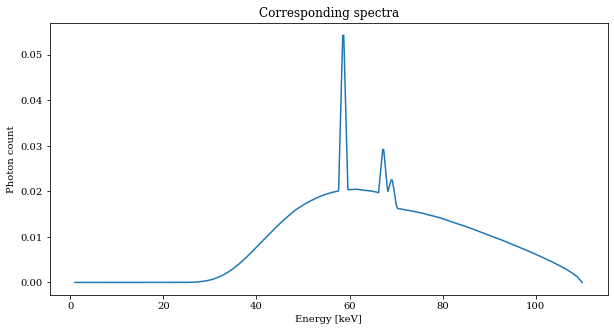

In [13]:
plt.figure(figsize=(10,5))
plt.plot(energy_set, bin_sets)
plt.xlabel("Energy [" + unit_of_energy + "]")
plt.ylabel("Photon count")
plt.title("Corresponding spectra")

## Load our samples

In [14]:
json2gvxr.initSamples("JSON/PoissonNoise.json", verbose=1)

Load the 3D data

	Load internals in /content/JSON/../input_data/welsh-dragon-small.stl using mm


In [15]:
gvxr.moveToCentre()

ID = "root"
min_x, min_y, min_z, max_x, max_y, max_z = gvxr.getNodeAndChildrenBoundingBox(ID, "mm")
centre_x = (min_x + max_x) / 2.0
centre_y = (min_y + max_y) / 2.0
centre_z = (min_z + max_z) / 2.0

print("Bounding box:", [min_x, min_y, min_z], [max_x, max_y, max_z])
print("Bounding box centre:", [centre_x, centre_y, centre_z])

Bounding box: [-34.22738265991211, -77.55621337890625, -62.217071533203125] [34.227378845214844, 77.55621337890625, 62.217041015625]
Bounding box centre: [-1.9073486328125e-06, 0.0, -1.52587890625e-05]


## Let's get an x-ray image

We create an X-ray image `projection_in_MeV`. 
By default the image is expressed in MeV. 
We convert it to keV for display as follows: `projection_in_keV = projection_in_MeV / gvxr.getUnitOfEnergy("keV")`.

In [16]:
projection_in_MeV = np.array(gvxr.computeXRayImage(), dtype=np.single)
projection_in_keV = projection_in_MeV / gvxr.getUnitOfEnergy("keV")

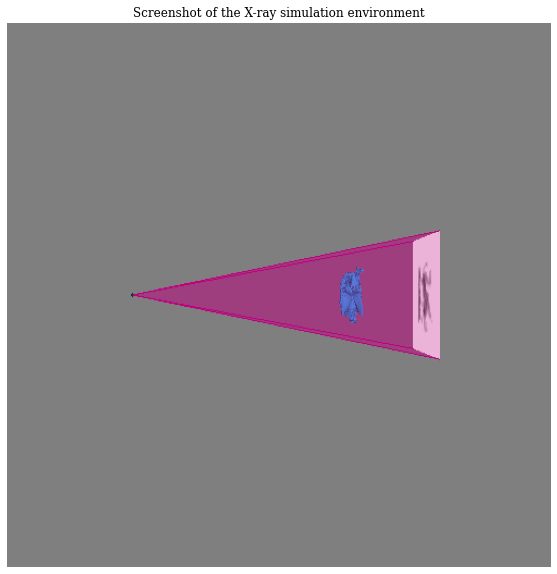

In [17]:
gvxr.displayScene()
plotScreenshot()

In [18]:
fname = raw_projection_output_dir + "/../visualisation.png"

if not os.path.exists(fname):

    from google.colab import output
    output.enable_custom_widget_manager()

    plot = visualise(use_log=True)
    plot.grid_visible = False
    plot.display()
else:
    display(Image(fname, width=800))

In [19]:
if not os.path.exists(fname):
    if plot is not None:
    
        plot.fetch_screenshot()

        data = base64.b64decode(plot.screenshot)
        with open(raw_projection_output_dir + "/../visualisation.png",'wb') as fp:
            fp.write(data)

    from google.colab import output
    output.disable_custom_widget_manager()

## Add Poisson noise

1. Load the raw projection in the RAM
2. Convert the image in keV or MeV into number of photons
3. Add the Poisson noise
4. Convert the image in number of photons into keV or MeV
5. Apply the flat-field correction

In [20]:
def getNoisyImage(x_ray_image_energy, target_number_of_photons_per_pixel):
    
    total_energy_MeV = gvxr.getTotalEnergyWithDetectorResponse()
    number_of_incident_photons_per_pixel = np.sum(gvxr.getPhotonCountEnergyBins())
    energy2photons = number_of_incident_photons_per_pixel / total_energy_MeV

    temp = energy2photons / number_of_incident_photons_per_pixel * target_number_of_photons_per_pixel
    
    # Convert the image in keV into number of photons
    x_ray_image_photons = x_ray_image_energy * temp 
    
    # Add the Poisson noise
    noise_image = np.float32(np.random.poisson(x_ray_image_photons))

    # Convert in energy
    return noise_image / temp

In [21]:
fig_plot = None
def chooseNumberOfPhotonsPerPixel(xray_image: np.array, number_of_photons_per_pixel:int=15000, figsize=(10, 5)):

    """
    Use Matplotlib and a Jupyter widget to display the X-ray image with Poisson noise.
    The number of photons per pixel can be change interactively.

    @param xray_image: The image to display
    @number_of_photons_per_pixel: the number of photons per pixel (default: 15000)
    @gamma figsize: the size of the figure (default: (10, 5))
    """

    global target_number_of_photons_per_pixel, fig_plot
    target_number_of_photons_per_pixel = number_of_photons_per_pixel

    noisy_image = getNoisyImage(xray_image, number_of_photons_per_pixel)

    fig_plot = plt.figure(figsize=figsize)
    ax_img = plt.subplot(111)
    img = plt.imshow(noisy_image, cmap="gray")
    # cbar = fig_plot.colorbar(img, orientation='vertical')
    title_str = "Photons per pixels: " + str(number_of_photons_per_pixel)
    ax_img.set_title(title_str)
    plt.tight_layout()
    plt.margins(0,0)

    plt.close()

    ## Callback function: plot y=Acos(x+phi)
    def update_plot(number_of_photons_per_pixel):
        global target_number_of_photons_per_pixel
        target_number_of_photons_per_pixel = number_of_photons_per_pixel
        noisy_image = getNoisyImage(xray_image, number_of_photons_per_pixel)
        img = ax_img.imshow(noisy_image, cmap="gray")
        title_str = "Photons per pixels: " + str(number_of_photons_per_pixel)
        ax_img.set_title(title_str)
        # fig_plot.colorbar(img, cax=cbar.ax, orientation='vertical')

        display(fig_plot)

    interact(update_plot,
             number_of_photons_per_pixel=widgets.IntSlider(value=number_of_photons_per_pixel, min=10, max=50000, step=10, description="Photons/pixels"))

In [22]:
chooseNumberOfPhotonsPerPixel(projection_in_MeV, number_of_photons_per_pixel=5000, figsize=(10, 5))

interactive(children=(IntSlider(value=5000, description='Photons/pixels', max=50000, min=10, step=10), Output(…

In [23]:
fig_plot.savefig(raw_projection_output_dir + "/../noisy-projection.png", dpi=72)

In [24]:
print("Photons per pixels:", target_number_of_photons_per_pixel)

Photons per pixels: 5000


## Perfom the CT scan

In [25]:
angles = json2gvxr.initScan()

Set up the CT Scan


In [26]:
number_of_angles = json2gvxr.params["Scan"]["NumberOfProjections"]
angles = json2gvxr.doCTScan()

In [27]:
print("First angle:", angles[0])
print("Last angle:", angles[-1])
print("Number of angles:", number_of_angles)

First angle: 0.0
Last angle: 179.5
Number of angles: 360


## Flat images

Create the flat field image

In [28]:
white_slider = widgets.IntSlider(value=25, min=1, max=500, step=1, description='Number of flat images:')
white_slider

IntSlider(value=25, description='Number of flat images:', max=500, min=1)

In [29]:
print("Number of flat images:", white_slider.value)

Number of flat images: 25


In [30]:
createDirectory(raw_projection_output_dir + "/../flat-field")
fname = raw_projection_output_dir + "/../flat-field/flat.tif"

total_energy_MeV = gvxr.getTotalEnergyWithDetectorResponse()

temp = total_energy_MeV * np.ones([1, number_of_rows, number_of_cols], dtype=np.single)
flats = []

for i in range(white_slider.value):
    flats.append(getNoisyImage(temp, target_number_of_photons_per_pixel))

flat_field = np.average(flats, axis=0)

imwrite(fname, flat_field.astype(np.single), compression='zlib')

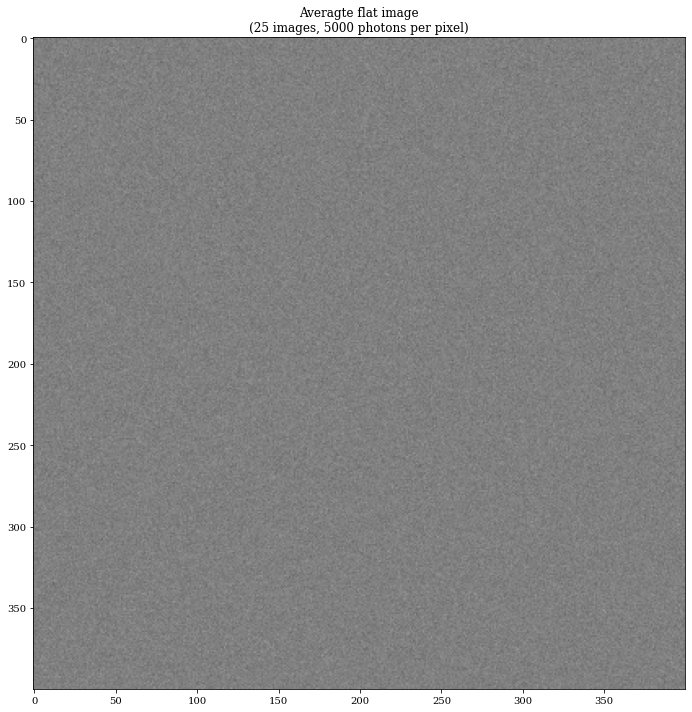

In [31]:
fig = plt.figure(figsize = (20, 10))
plt.title("Averagte flat image\n(" + str(white_slider.value) + " images, " + str(target_number_of_photons_per_pixel) + " photons per pixel)")
img = plt.imshow(flat_field[0], cmap='gray', vmin=total_energy_MeV-0.05*total_energy_MeV, vmax=total_energy_MeV+0.05*total_energy_MeV)
plt.tight_layout()
plt.savefig(raw_projection_output_dir + "/../average-flat-field.png", dpi=72)

## Add the noise to the projections

In [32]:
createDirectory(raw_projection_output_dir + "/../noiseless_projections")

raw_projections = []
for i in range(number_of_angles):

    print("Projection", i + 1, "/", number_of_angles, end='\r')

    input_fname = raw_projection_output_dir + "/projection-" + '{0:04d}'.format(i+1) + ".tiff"
    output_fname = raw_projection_output_dir + "/../noiseless_projections/projection-" + '{0:04d}'.format(i+1) + ".tiff"
    
    # Load the raw projection in the RAM
    x_ray_image_energy = imread(input_fname).astype(np.single)

    # Save it
    imwrite(output_fname, x_ray_image_energy)

    # Add the Poisson noise
    noise_image = getNoisyImage(x_ray_image_energy, target_number_of_photons_per_pixel)

    # Flat-field
    x_ray_image_energy = noise_image / flat_field[0]
    raw_projections.append(x_ray_image_energy.astype(np.single))

    # Overwrite the image
    imwrite(input_fname, raw_projections[-1])

## CT reconstruction

In [33]:
def reconstructFBPWithCIL(data, ig, verbose):
    if verbose > 0: print("Parallel beam detected")

    if has_tigre:
        if verbose > 0: print("Backend: Tigre")
        reconstruction:ImageData | None = FBP(data, ig).run()
    else:
        if verbose > 0: print("Backend: Astra-Toolbox")
        reconstruction:ImageData | None = FBP(data, ig, backend="astra").run()

    return reconstruction

In [34]:
def reconstructFDKWithCIL(data, ig, verbose):
    if verbose > 0: print("Cone beam detected")

    if has_tigre:
        if verbose > 0: print("Backend: Tigre")
        reconstruction:ImageData | None = FDK(data, ig).run()
    else:
        if verbose > 0: print("Backend: Astra-Toolbox")
        fbk = FDK_Flexible(ig, data.geometry)
        fbk.set_input(data)
        reconstruction:ImageData | None = fbk.get_output()
    
    return reconstruction

In [35]:
def reconstructFBPWithRTK(verbose):
    if not has_rtk:
        raise ValueError("RTK is not installed")

    if verbose > 0: print("Parallel beam detected")
    if verbose > 0: print("Backend: RTK")
    
    raise ValueError("Not currently supported")
    
    return None

In [75]:
def reconstructFDKWithRTK(verbose):
    if not has_rtk:
        raise ValueError("RTK is not installed")

    if verbose > 0: print("Cone beam detected")
    if verbose > 0: print("Backend: RTK")
    
    source_position = np.array(gvxr.getSourcePosition("mm"))
    detector_position = np.array(gvxr.getDetectorPosition("mm"))
    isocentre = np.array(json2gvxr.params["Scan"]["CenterOfRotation"])

    sid = np.linalg.norm(source_position - isocentre) # source to isocenter distance
    sdd = np.linalg.norm(source_position - detector_position) # source to detector distance

    detector_size = np.array(gvxr.getDetectorSize("mm"))
    number_of_pixels = np.array(gvxr.getDetectorNumberOfPixels())
    detector_spacing = detector_size / number_of_pixels

    print("source_position:", source_position, "mm")
    print("detector_position:", detector_position, "mm")
    print("isocentre:", isocentre, "mm")

    print("sid:", sid, "mm")
    print("sdd:", sdd, "mm")

    print("detector_size:", detector_size, "mm")
    print("number_of_pixels:", number_of_pixels)
    print("detector_spacing:", detector_spacing, "mm")

    # Defines the image type
    ImageType = itk.Image[itk.F, 3]

    # Defines the RTK geometry object
    geometry = rtk.ThreeDCircularProjectionGeometry.New()

    for angle in angles:
        geometry.AddProjection(sid, sdd, angle)

    print("First angle:", angles[0])
    print("Last angle:", angles[-1])
    print("Number of angles:", len(angles))                    

    # Writing the geometry to disk
    xmlWriter = rtk.ThreeDCircularProjectionGeometryXMLFileWriter.New()
    xmlWriter.SetFilename ( raw_projection_output_dir + "/../rtk-geometry.xml" )
    xmlWriter.SetObject ( geometry )
    xmlWriter.WriteFile()

    # Get the file names
    file_names = sorted(glob.glob(os.path.join(raw_projection_output_dir,  '*projection-*.tiff')))
    sorted_file_names = file_names

    # Read the data
    reader = itk.ImageSeriesReader[ImageType].New()
    reader.SetFileNames(sorted_file_names)
    projections = reader.GetOutput()
    projections.SetOrigin( [-detector_size[0] / 2, -detector_size[1] / 2, 0.0])
    projections.SetSpacing( [detector_spacing[0], detector_spacing[1], detector_spacing[0]] )

    # Create a stack of empty projection images
    WriterType = rtk.ImageFileWriter[ImageType]
    writer = WriterType.New()


    # Create reconstructed image
    ConstantImageSourceType = rtk.ConstantImageSource[ImageType]
    constantImageSource2 = ConstantImageSourceType.New()
    sizeOutput = [ int(number_of_pixels[0]), int(number_of_pixels[0]), int(number_of_pixels[1]) ]
    spacing = [ detector_spacing[0], detector_spacing[0], detector_spacing[1] ]
    origin = [
        -detector_size[0] / 2 + detector_spacing[0] / 2,
        -detector_size[0] / 2 + detector_spacing[0] / 2,
        -detector_size[1] / 2 + detector_spacing[1] / 2]

    constantImageSource2.SetOrigin( origin )
    constantImageSource2.SetSpacing( spacing )
    constantImageSource2.SetSize( sizeOutput )
    constantImageSource2.SetConstant(0.)

    print("sizeOutput:", sizeOutput)
    print("origin:", origin)
    print("spacing:", spacing)
                
    # writer.SetFileName("const2.mha")
    # writer.SetInput(constantImageSource2.GetOutput())
    # writer.Update()                

    # FDK reconstruction
    print("Reconstructing...")
    FDKCPUType = rtk.FDKConeBeamReconstructionFilter[ImageType]
    feldkamp = FDKCPUType.New()
    feldkamp.SetInput(0, constantImageSource2.GetOutput())
    feldkamp.SetInput(1, projections)
    feldkamp.SetGeometry(geometry)
    feldkamp.GetRampFilter().SetTruncationCorrection(0.0)
    feldkamp.GetRampFilter().SetHannCutFrequency(0.0)
    feldkamp.Update()

    # writer.SetFileName("feldkamp.mha")
    # writer.SetInput(feldkamp.GetOutput())
    # writer.Update()                

    # writer.SetFileName("const2.mha")
    # writer.SetInput(constantImageSource2.GetOutput())
    # writer.Update()                

    # Field-of-view masking
    FOVFilterType = rtk.FieldOfViewImageFilter[ImageType, ImageType]
    fieldofview = FOVFilterType.New()
    fieldofview.SetInput(0, feldkamp.GetOutput())
    fieldofview.SetProjectionsStack(projections)
    fieldofview.SetGeometry(geometry)
    fieldofview.Update()

    # writer.SetFileName("fieldofview.mha")
    # writer.SetInput(fieldofview.GetOutput())
    # writer.Update()

    print("origin of reconstructed volume:", feldkamp.GetOutput().GetOrigin())
    print("spacing of reconstructed volume:", feldkamp.GetOutput().GetSpacing())

    return feldkamp.GetOutput()

In [76]:
def reconstruct(JSON_fname, verbose=0):
    
    data = None
    reconstruction = None
    
    source_shape = json2gvxr.params["Source"]["Shape"]

    if verbose > 0:
        print("Source shape:", source_shape)

    # Use CIL
    if has_cil:
    
        if verbose > 0: print("Use CIL")

        reader = JSON2gVXRDataReader(file_name=JSON_fname)
        data = reader.read()

        print("data.geometry", data.geometry)
        
        if has_tigre:
            data.reorder(order='tigre')
            data.geometry.set_angles(-data.geometry.angles)
        else:
            data.reorder("astra")

        ig = data.geometry.get_ImageGeometry()

        data_corr = TransmissionAbsorptionConverter(white_level=data.max(), min_intensity=0.000001)(data)

        if type(source_shape) == str:

            if source_shape.upper() == "PARALLELBEAM" or source_shape.upper() == "PARALLEL":
                reconstruction:ImageData | None = reconstructFBPWithCIL(data_corr, ig, verbose)

            elif source_shape.upper() == "POINTSOURCE" or source_shape.upper() == "POINT" or source_shape.upper() == "CONE" or source_shape.upper() == "CONEBEAM":
                reconstruction:ImageData | None = reconstructFDKWithCIL(data_corr, ig, verbose)

            else:
                raise ValueError("Unknown source shape:" + source_shape)

        elif type(source_shape) == type([]):
            if source_shape[0].upper() == "FOCALSPOT":
                reconstruction:ImageData | None = reconstructFDKWithCIL(data_corr, ig, verbose)

            else:
                raise ValueError("Unknown source shape:" + source_shape)

        else:
            raise ValueError("Unknown source shape:" + source_shape)    

    # Use ITK-RTK
    elif has_rtk:
        if verbose > 0: print("Use RTK")

        if type(source_shape) == str:

            if source_shape.upper() == "PARALLELBEAM" or source_shape.upper() == "PARALLEL":
                reconstruction = reconstructFBPWithRTK(verbose)
                
            elif source_shape.upper() == "POINTSOURCE" or source_shape.upper() == "POINT" or source_shape.upper() == "CONE" or source_shape.upper() == "CONEBEAM":
                reconstruction = reconstructFDKWithRTK(verbose)
                
            else:
                raise ValueError("Unknown source shape:" + source_shape)

        elif type(source_shape) == type([]):
            if source_shape[0].upper() == "FOCALSPOT":
                reconstruction = reconstructFDKWithRTK(verbose)

            else:
                raise ValueError("Unknown source shape:" + source_shape)

        else:
            raise ValueError("Unknown source shape:" + source_shape)    

    else:
        raise ValueError("CIL and RTK are not installed")    

    return data, reconstruction

In [77]:
has_tigre = False # Make sure we use astra
has_cil = False # Make sure we use ITK-RTK

data, reconstruction = reconstruct("JSON/PoissonNoise.json", verbose=1)

Source shape: PointSource
Use RTK
Cone beam detected
Backend: RTK
source_position: [-600.    0.    0.] mm
detector_position: [200.   0.   0.] mm
isocentre: [0 0 0] mm
sid: 600.0 mm
sdd: 800.0 mm
detector_size: [320. 320.] mm
number_of_pixels: [400 400]
detector_spacing: [0.8 0.8] mm
First angle: 0.0
Last angle: 179.5
Number of angles: 360
sizeOutput: [400, 400, 400]
origin: [-159.6, -159.6, -159.6]
spacing: [0.8, 0.8, 0.8]
Reconstructing...
origin of reconstructed volume: itkPointD3 ([-159.6, -159.6, -159.6])
spacing of reconstructed volume: itkVectorD3 ([0.8, 0.8, 0.8])


In [57]:
if has_cil:
    fig = show_geometry(data.geometry)
    fig.save(raw_projection_output_dir + "/../CT-geometry.png", dpi=72)

In [58]:
if has_cil_islider:
    islicer(reconstruction, direction='vertical')

In [59]:
if has_cil_islider:
    islicer(reconstruction, direction='horizontal_x')

In [60]:
createDirectory(raw_projection_output_dir + "/../reconstructions")
fname = raw_projection_output_dir + "/../reconstructions/CT_in_mu.mha"

In [61]:
if has_cil:

    reconstruction_as_array = reconstruction.as_array()
    detector_size = np.array(gvxr.getDetectorSize("mm"))
    number_of_pixels = np.array(gvxr.getDetectorNumberOfPixels())
    spacing = detector_size / number_of_pixels
    sitk_image = sitk.GetImageFromArray(reconstruction_as_array)
    sitk_image.SetSpacing([spacing[0], spacing[0], spacing[1]])
    sitk.WriteImage(sitk_image, fname, useCompression=True)

In [78]:
if has_rtk:

    # Defines the image type
    ImageType = itk.Image[itk.F, 3]

    # Create a stack of empty projection images
    WriterType = rtk.ImageFileWriter[ImageType]
    writer = WriterType.New()
    writer.SetFileName(fname)
    writer.SetInput(reconstruction)
    writer.Update()                

RuntimeError: ignored

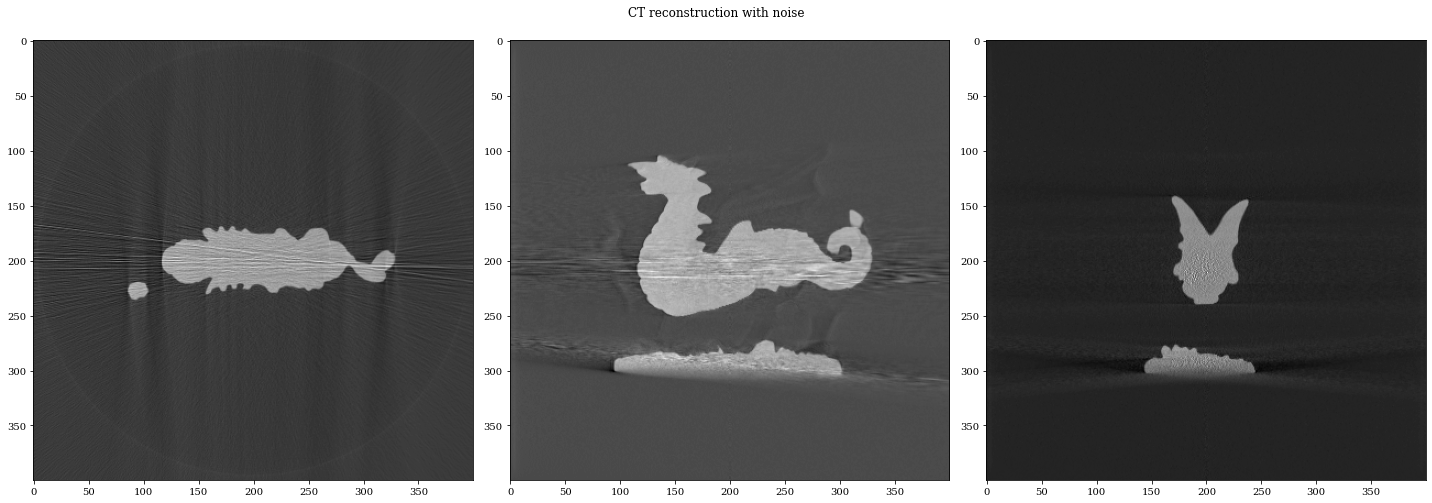

In [ ]:
if has_cil:
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (20, 7))
    plt.suptitle("CT reconstruction with noise")
    ax1.imshow(np.flip(reconstruction_as_array[ reconstruction_as_array.shape[0] // 2, :, :], axis=0), cmap='gray')
    ax2.imshow(np.flip(reconstruction_as_array[ :, reconstruction_as_array.shape[1] // 2, :], axis=0), cmap='gray')
    ax3.imshow(np.flip(reconstruction_as_array[ :, :, reconstruction_as_array.shape[2] // 2], axis=0), cmap='gray')
    plt.tight_layout()
    plt.savefig(raw_projection_output_dir + "/../plotCT.png", dpi=72)

# Cleaning up

Once we have finished it is good practice to clean up the OpenGL contexts and windows with the following command.

In [ ]:
gvxr.terminate()